# Language Classification

## Overview

My aim here is to build a language classifier for EU languages.

Proposed Approach:
1. Inspect test set
1. Create dataset for training / validation
1. Train / valid split
1. Numericalize
1. Create embeddings
1. Build language classification model

## Setup

In [ ]:
#from os import path
#from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
#platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

#accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from collections import Counter
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import utils

In [3]:
np.random.seed(1)

In [4]:
def word_count(x): return len(x.split())
def sentence_count(x): return len(x.split('<eos>')) - 1

## Settings

In [5]:
PATH = Path('data')
TRAIN = PATH/'train_sampl'
TEST_FN = PATH/'test'
PATH_TMP = PATH/'tmp'

MIN_FREQ = 20

BS = 64

EMB_SZ = 1000

LANGS = list(map(lambda x: x.name, list(TRAIN.iterdir())))

In [6]:
PATH_TMP.mkdir(parents=True, exist_ok=True)

## Clarify Goal

In [7]:
test = pd.read_csv(TEST_FN, sep = '\t', lineterminator='\n', header=None)
test.rename({0:'label', 1:'text'}, axis = 1, inplace=True)

In [8]:
test.head()

,label,text
0,bg,Европа 2020 не трябва да стартира нов конкурен...
1,bg,(CS) Най-голямата несправедливост на сегашната...
2,bg,"(DE) Г-жо председател, г-н член на Комисията, ..."
3,bg,"(DE) Г-н председател, бих искал да започна с к..."
4,bg,"(DE) Г-н председател, въпросът за правата на ч..."


In [10]:
test['text'] = test['text'].apply(utils.preprocess)

In [11]:
test[test['label']=='en'].iloc[0]["text"]

'<punct> BG <punct> Thank you <punct> Mr President <eos>'

In [12]:
test[test['label']=='de'].iloc[0]["text"]

'<punct> BG <punct> Herr Kommissar <eos> Das Dokument <punct> das vom Europäischen Parlament angenommen werden soll <punct> ist in der Tat sehr wichtig <eos>'

In [13]:
test['text'].apply([sentence_count, word_count, len]).describe()

,sentence_count,word_count,len
count,20828.000000,20828.000000,20828.000000
mean,1.113837,26.071922,175.205541
std,0.851456,25.298060,167.062078
min,1.000000,3.000000,22.000000
25%,1.000000,15.000000,99.000000
50%,1.000000,23.000000,154.000000
75%,1.000000,33.000000,224.000000
max,77.000000,2184.000000,14069.000000


## Preprocess Training Dataset

In [20]:
exampl = utils.concat_docs('en', TRAIN)
exampl[:200]

'<CHAPTER ID="012">\nApproval of the minutes of the previous sitting: see Minutes\n<CHAPTER ID="011">\nClimate and energy package and maritime transport package (signature of acts) \n<SPEAKER ID="333" NAME'

In [21]:
exampl = utils.txt2list(exampl)
exampl[:2]

['Approval of the minutes of the previous sitting <punct> see Minutes <eos>',
 'Climate and energy package and maritime transport package <punct> signature of acts <punct> <eos>']

In [23]:
dfs = []
for lang in LANGS:
    print(' '+lang+' ', end = "")
    txt = utils.concat_random_sent(utils.txt2list(utils.concat_docs(lang, TRAIN)))
    temp_df = pd.DataFrame({'text':txt})
    temp_df['label'] = lang
    dfs.append(temp_df)
df = pd.concat(dfs)[['label', 'text']]
df.reset_index(inplace=True, drop = True)

 fi  et  it  lt  pt  lv  nl  pl  bg  en  sk  fr  da  hu  cs  sl  es  el  ro  de  sv 

In [24]:
df.head()

,label,text
0,fi,Suulliset kysymykset ja kirjalliset kannanotot...
1,fi,pöytäkirja <eos>
2,fi,Ihmisoikeudet sekä sosiaali <punct> ja ympäris...
3,fi,<punct> DE <punct> Esityslistalla on seuraavan...
4,fi,Tokia Saïfin kansainvälisen kaupan valiokunnan...


In [25]:
df['text'].apply([sentence_count, word_count, len]).describe()

,sentence_count,word_count,len
count,298576.000000,298576.000000,298576.000000
mean,1.020132,25.547683,168.444379
std,0.142041,16.804757,111.040280
min,1.000000,2.000000,16.000000
25%,1.000000,14.000000,90.000000
50%,1.000000,22.000000,147.000000
75%,1.000000,33.000000,220.000000
max,3.000000,694.000000,4954.000000


## Train Test Split

In [26]:
len(df)

298576

In [27]:
X_train, X_val, y_train, y_val = train_test_split(np.array(df['text']), np.array(df['label']), 
                                                  test_size=0.01, random_state=42)

In [28]:
y_train

array(['sv', 'it', 'sv', ..., 'en', 'fr', 'en'], dtype=object)

## Numericalize

In [29]:
words = Counter()
for row in X_train: words.update(row.split())
words.most_common(10)

[('<punct>', 604149),
 ('<eos>', 301556),
 ('de', 135517),
 ('a', 71678),
 ('<num>', 64662),
 ('the', 58204),
 ('en', 49973),
 ('la', 49668),
 ('in', 43814),
 ('que', 41364)]

In [30]:
words = {k:v for k, v in words.items() if v >= MIN_FREQ}
words = sorted(words, key=words.get, reverse=True)
words = ['<unk>','<pad>'] + words

In [31]:
vocab_size = len(words)
vocab_size

33485

In [32]:
word2idx = defaultdict(lambda: 0, {o:i for i,o in enumerate(words)})
idx2word = defaultdict(lambda: '<unk>', {i:o for i,o in enumerate(words)})

In [33]:
print([word2idx[w] for w in X_train[0].split()])

[273, 2671, 6349, 8803, 53, 209, 1387, 2, 64, 1387, 0, 48, 0, 0, 3]


In [34]:
X_train = utils.numericalize(X_train, word2idx)
X_val = utils.numericalize(X_val, word2idx)

In [35]:
utils.de_numericalize(X_train[:2], idx2word)

['Den borde försöka dra med sig medlemsstaterna <punct> för medlemsstaterna <unk> på <unk> <unk> <eos>',
 'Infatti l <punct> Assemblea li <unk> ad istituire sistemi pensionistici più adeguati per assicurare un <unk> di vita <unk> per tutti <punct> <unk> un <punct> attenzione particolare alle categorie più <unk> della società <eos>']

## Create Embeddings

In [36]:
m, n = X_train.shape

In [37]:
idx_freq = Counter()
for row in X_train: idx_freq.update(row)
idx_freq = np.array([idx_freq[i] for i in range(len(idx_freq))]).astype(np.int32)

In [38]:
[(x, utils.subsamp_disc_prob(idx_freq)[word2idx[x]]) for x in 
 ['the', 'in', 'of', 'president', 'approval', 'origin']]

[('the', 0.9637772558403621),
 ('in', 0.9584221102140329),
 ('of', 0.9500464673857614),
 ('president', 0.5517612991263541),
 ('approval', 0.0),
 ('origin', 0.0)]

In [39]:
X_skip, y_skip = utils.skipgram_data(X_train, idx_freq)
skip_dl = DataLoader(TensorDataset(X_skip, y_skip), batch_size=BS)

In [41]:
class skip_model(nn.Module):
    def __init__(self, emb_sz = EMB_SZ, vocab_size = vocab_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_sz)
        self.target_emb = nn.Embedding(vocab_size, emb_sz)
        self.emb.weight.data.uniform_(-0.05, 0.05)
        self.target_emb.weight.data.uniform_(-0.05, 0.05)
        
    def forward(self, x):
        context, target = x[:, 0], x[:, 1]
        context, target = self.emb(context), self.target_emb(target)
        res = (context * target).sum(1)
        res = torch.sigmoid(res)
        return res.squeeze()

In [42]:
model = skip_model()

In [43]:
loss_func = nn.BCELoss()  # Binary cross entropy loss

In [44]:
def loss_batch(xb, yb, model, loss_func, opt):
    '''https://github.com/fastai/fastai_v1/blob/master/dev_nb/001a_nn_basics.ipynb'''
    # Note: changed this by adding yb.view(-1) to match dimensions

    loss = loss_func(model(xb), yb.view(-1))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [50]:
class Learner(object):
    
    def __init__(self, model, loss_func, train_dl = None, valid_dl = None):
        self.model = model
        self.loss_func = loss_func
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.losses = []
    
    def lr_find(self, start = 1e-5, return_losses = False, exp_smooth = True):
        lr = start; lrs = []; losses = []
        self.model.train()
        i = 0
        for xb,yb in tqdm(self.train_dl, position=0):
            opt = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
            l = self.loss_func(self.model(xb), yb.view(-1))
            l.backward(); opt.step(); opt.zero_grad()
            if exp_smooth or i ==0:
                loss = l.detach().numpy()
            else:
                loss = 0.9*loss + l.detach().numpy()            
            lrs.append(lr), losses.append(loss)
            if i > 10 and loss > 5*np.mean(losses[:i]):
                break
            if lr > 1000:
                break
            lr = lr*1.05
            i += 1        
        f, ax = plt.subplots(figsize=(5, 5))
        ax.set(yscale = 'log', xscale = 'log')
        ax = plt.plot(lrs, losses)
        self.losses = losses
        if return_losses: return (lrs, losses)
        
    def plot_loss(self):
        f, ax = plt.subplots(figsize=(5, 5))
        ax.set(yscale = 'log')
        ax = plt.plot(self.losses)
            
    def fit(self, lr, epochs, callOn_epoch_start = None):
        
        self.opt = optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        loss_list = []
        
        for epoch in range(epochs):
            
            if callOn_epoch_start:
                callOn_epoch_start()
        
            # Fit model to training data
            self.model.train()
            losses, nums = zip(*[loss_batch(xb, yb, self.model, self.loss_func, self.opt) 
                                 for xb,yb in tqdm(self.train_dl, position=0)])
            train_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
            loss_list = loss_list+list(losses)

            # Calculate loss on validation set
            if self.valid_dl != None:
                model.eval()
                with torch.no_grad():
                    losses,nums = zip(*[loss_batch(model, loss_func, xb, yb)
                                        for xb,yb in valid_dl])
                val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
            else:
                val_loss = 'N/A'
                
            print(f'Epoch {epoch}. Training loss: {train_loss}. Validation loss: {val_loss}.')
        self.losses = loss_list
            
class skipgram_Learner(Learner):
    def update_train(self):
        X_skip, y_skip = utils.skipgram_data(X_train, idx_freq)
        self.train_dl = DataLoader(TensorDataset(X_skip, y_skip), batch_size=BS)
        
    def fit(self, lr, epochs): 
        super().fit(lr, epochs, callOn_epoch_start=self.update_train)

In [51]:
learn = skipgram_Learner(model, loss_func, skip_dl)

In [52]:
learn.lr_find()

  0%|          | 9/4065 [00:03<22:09,  3.05it/s]

KeyboardInterrupt: 

In [53]:
learn.fit(0.1, 1)

  0%|          | 10/4098 [00:02<17:48,  3.83it/s]

KeyboardInterrupt: 

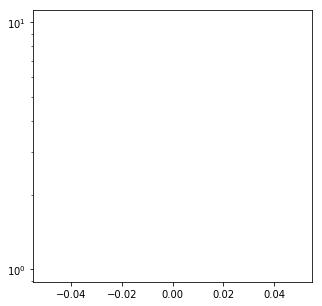

In [54]:
learn.plot_loss()

In [210]:
torch.save(sgFitter.model, PATH_TMP/'embeddings.pt')

/home/krisztian/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type skip_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [524]:
embs = sgFitter.model.emb.weight.data.numpy()

In [525]:
def cos_dist(u, v): return np.dot(u, v) / np.sqrt(np.sum(u**2)*np.sum(v**2))
def emb_pair_dist(a, b, c, d):
    return cos_dist(embs[word2idx[a]] - embs[word2idx[b]],
                   embs[word2idx[c]] - embs[word2idx[d]])

In [526]:
emb_pair_dist('man', 'woman', 'he', 'she')

0.032636125

In [527]:
emb_pair_dist('good', 'better', 'bad', 'worse')

0.0030198644